In [7]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
import re

### Machine Learning
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold , cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import statsmodels.api as sm
import statsmodels.formula.api as smf


plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
df = pd.read_csv('data/listing_final.csv')

In [4]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'zipcode', 'zvi',
       'now', 'review_period', 'number_of_days_as_host', 't'],
      dtype='object', length=102)

In [5]:
df.rename(index = str, columns ={'zvi' :'rent_index'}, inplace = True)
df.rename(str.lower , axis ='columns', inplace=True)

In [12]:
df_new = df[['bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people','number_of_reviews', 'rent_index', 'number_of_days_as_host',
       'amenities', 'price']]

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7708 entries, 0 to 7714
Data columns (total 12 columns):
bathrooms                 7708 non-null float64
bedrooms                  7708 non-null float64
beds                      7708 non-null float64
security_deposit          7708 non-null int64
cleaning_fee              7708 non-null int64
guests_included           7708 non-null int64
extra_people              7708 non-null int64
number_of_reviews         7708 non-null int64
rent_index                7708 non-null int64
number_of_days_as_host    7708 non-null float64
amenities                 7708 non-null int64
price                     7708 non-null int64
dtypes: float64(4), int64(8)
memory usage: 782.8+ KB


In [13]:
df_new=df_new.dropna()

### Variance Inflation factor

In [16]:
X = add_constant(df_new)
pd.Series([np.sqrt(variance_inflation_factor(X.values, i)) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                     8.175512
bathrooms                 1.225393
bedrooms                  1.728301
beds                      1.605910
security_deposit          1.094322
cleaning_fee              1.367539
guests_included           1.358793
extra_people              1.077444
number_of_reviews         1.074908
rent_index                1.035844
number_of_days_as_host    1.045136
amenities                 1.075485
price                     1.221478
dtype: float64

### p values

In [18]:
est=LinearRegression()
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[] # will be the list of all significant columns' p-values

for feature in df_new.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(df_new[[feature]],df_new.price) # univariate regression for feature selection ; gets f-value and p-value scores
    print(pval)
    if pval[1][0]<.02: 
        sig_columns.append(feature)
        pvals.append(pval[1][0])
        
df_new_trans=df_new[sig_columns]

cross_val_score(est,df_new_trans,df_new.price,cv=5,scoring='r2').mean() 

(array([868.55169872]), array([5.54322294e-181]))
(array([2178.39591443]), array([0.]))
(array([1510.99441735]), array([5.50016569e-302]))
(array([349.51350151]), array([2.59139055e-76]))
(array([2443.68868347]), array([0.]))
(array([1111.65903844]), array([8.19779327e-228]))
(array([139.77652228]), array([5.62292872e-32]))
(array([119.67340658]), array([1.19038897e-27]))
(array([244.27580037]), array([3.10857164e-54]))
(array([0.00435018]), array([0.94741466]))
(array([202.53567984]), array([2.18854824e-45]))
(array([-1.73523694e+19]), array([1.]))


0.29797781171618204

In [19]:
print(sig_columns)

['bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 'rent_index', 'amenities']


In [21]:
df_new = df[['bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people','number_of_reviews', 'rent_index',
       'amenities', 'price']]

In [22]:
df_new=df_new.dropna()

In [23]:
df_new.corr()

,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,rent_index,amenities,price
bathrooms,1.000000,0.535411,0.524410,0.113522,0.332607,0.366049,0.095694,-0.052200,-0.026022,0.121571,0.318301
bedrooms,0.535411,1.000000,0.758380,0.227206,0.530453,0.587148,0.148329,-0.014895,0.078537,0.178881,0.469479
beds,0.524410,0.758380,1.000000,0.203171,0.470090,0.536203,0.112352,0.001359,0.060846,0.183563,0.404932
security_deposit,0.113522,0.227206,0.203171,1.000000,0.380636,0.260764,0.132433,-0.009131,0.097788,0.190307,0.208356
cleaning_fee,0.332607,0.530453,0.470090,0.380636,1.000000,0.481029,0.252553,-0.080368,0.164347,0.247761,0.490739
guests_included,0.366049,0.587148,0.536203,0.260764,0.481029,1.000000,0.332554,0.053831,0.062743,0.234378,0.355111
extra_people,0.095694,0.148329,0.112352,0.132433,0.252553,0.332554,1.000000,0.033766,0.031982,0.104480,0.133492
number_of_reviews,-0.052200,-0.014895,0.001359,-0.009131,-0.080368,0.053831,0.033766,1.000000,0.044698,0.204977,-0.123922
rent_index,-0.026022,0.078537,0.060846,0.097788,0.164347,0.062743,0.031982,0.044698,1.000000,0.059201,0.175366
amenities,0.121571,0.178881,0.183563,0.190307,0.247761,0.234378,0.104480,0.204977,0.059201,1.000000,0.159704


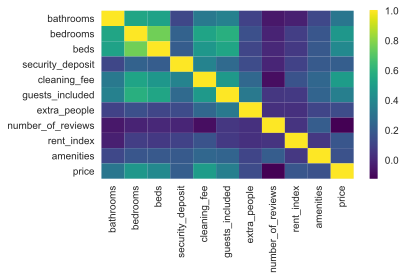

In [24]:
sns.heatmap(df_new.corr(), cmap="viridis");
#plt.figure(figsize=(10,10))
plt.tight_layout()
plt.savefig('correlation_plot.png', dpi=300)

In [25]:
X = df_new[['bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'number_of_reviews', 'rent_index', 'amenities']]
y = df_new['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 97)

In [26]:
ab_lr = LinearRegression()

In [27]:
ab_lr.fit(X_train , y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
ab_lr.score(X_train,y_train)

0.3387133975021257

In [29]:
s = ab_lr.score(X_test, y_test)
r = np.sqrt(mean_squared_error(y_test, ab_lr.predict(X_test)))
print('R^2:', s, 'RMSE:' , r)

R^2: 0.30164804235999876 RMSE: 95.21443716180934


### Statsmodels

In [30]:
lm1 = smf.ols('price ~ bathrooms + bedrooms + beds + security_deposit + cleaning_fee + guests_included + extra_people + number_of_reviews + rent_index + amenities', data = df_new)

# Fit your model to your training set
fit_lm1 = lm1.fit()

# Print summary statistics of the model's performance
fit_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     378.0
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        02:06:30   Log-Likelihood:                -46112.
No. Observations:                7709   AIC:                         9.225e+04
Df Residuals:                    7698   BIC:                         9.232e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -60.0359      8.871     -6.768      0.000     -77.425     -42.646
bathrooms            10.4978      1.767      5.941      0.000       7.034      13.961
bedrooms             23.4808      1.751     13.408      0.000      20.048      26.914
beds                  2.9145      1.033      2.822      0.005       0.890       4.939
security_deposit      0.0062      0.007      0.860      0.390      -0.008       0.020
cleaning_fee          0.6491      0.029     22.391      0.000       0.592       0.706
guests_included       2.2433      0.818      2.744      0.006       0.640       3.846
extra_people          0.0176      0.046      0.379      0.705      -0.073       0.109
number_of_reviews    -0.2602      0.023    -11.427      0.000      -0.305      -0.216
rent_index            0.0536      0.005     11.720      0.000       0.045       0.063
amenities             0.4673      0.109      4.287      0.000       0.254       0.681
==============================================================================
Omnibus:                     4102.673   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           109133.118
Skew:                           2.015   Prob(JB):                         0.00
Kurtosis:                      20.987   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""